In [1]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")

c:\Users\yaoji\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import pandas as pd
df = pd.read_csv('../question_answer_pair_3.csv')
df_context = pd.read_csv('../abstractive_summaries.csv')

In [20]:
df_context

,context
0,The World Health Organization announced the No...
1,Cancer is frequent in dogs and is by far their...
2,15 ARTDs have been linked previously to restri...
3,We found that granule cell neurons GCN of the ...
4,CJPH social media aims to engage our followers...
5,"iBS etiology is still not well understood, how..."
6,HF is an emerging epidemic with more than 26 m...
7,nitrogen dioxide NO2 is an important chemical ...
8,According to the importance of rapid tests in ...
9,professional burnout is an important issue for...


In [21]:
df_context['Topic']=df_context.index

In [22]:

merged_df = pd.merge(df, df_context, on='Topic', how='left')
merged_df

,Topic,TaggedSentence,Answer,Question,context
0,0,The [HL] World Health Organization [HL] announ...,World Health Organization,Who announced the Novel Coronavirus SARS-CoV-2...,The World Health Organization announced the No...
1,0,The World Health Organization announced the No...,pandemic March,What did the World Health Organization announc...,The World Health Organization announced the No...
2,0,Since the WHO has warned about the beginning o...,equipment protocols,"Since the beginning of the pandemic in March, ...",The World Health Organization announced the No...
3,0,Since the WHO has warned about the beginning o...,medical institutions,Where have basic protective equipment and safe...,The World Health Organization announced the No...
4,0,[HL] healthcare workers [HL] are experiencing ...,healthcare workers,Who are experiencing pressure from stressors?,The World Health Organization announced the No...
...,...,...,...,...,...
1039,32,most studies have dealt with the degradation o...,single leachate,What studies have dealt with degradation of si...,Plastic pollution has become an increasing con...
1040,32,[HL] Leachate [HL] is a form of organic acid.,Leachate,What is a form of organic acid?,Plastic pollution has become an increasing con...
1041,32,Leachate is a form of [HL] organic acid [HL].,organic acid,What is leachate a form of?,Plastic pollution has become an increasing con...
1042,32,[HL] It [HL] is produced by the decomposition ...,It,How is water produced?,Plastic pollution has become an increasing con...


In [23]:
merged_df = merged_df.rename(columns={"Answer": "answers", "Question" : "question", "Abstractive Summary" : "context"})

# Convert the updated DataFrame to a list of dictionaries for question-answering
qa_data_cleaned = merged_df[['question', 'answers', 'context']]

In [24]:
qa_data_cleaned['answers'] = qa_data_cleaned['answers'].astype(str)
qa_data_cleaned['question'] = qa_data_cleaned['question'].astype(str)
qa_data_cleaned['context'] = qa_data_cleaned['context'].astype(str)

C:\Users\yaoji\AppData\Local\Temp\ipykernel_26348\2725166270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_data_cleaned['answers'] = qa_data_cleaned['answers'].astype(str)
C:\Users\yaoji\AppData\Local\Temp\ipykernel_26348\2725166270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_data_cleaned['question'] = qa_data_cleaned['question'].astype(str)
C:\Users\yaoji\AppData\Local\Temp\ipykernel_26348\2725166270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [25]:
import pandas as pd

# Assuming df is your pandas DataFrame

# Define a function to find the start position of the answer in the context
def find_answer_start(context, answer):
    return context.find(answer)

# Adjust the 'answers' column to match the expected structure
qa_data_cleaned['answers'] = qa_data_cleaned.apply(lambda row: {'text': [row['answers']], 'answer_start': [find_answer_start(row['context'], row['answers'])]}, axis=1)

# Show the updated DataFrame
qa_data_cleaned

C:\Users\yaoji\AppData\Local\Temp\ipykernel_26348\775699054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_data_cleaned['answers'] = qa_data_cleaned.apply(lambda row: {'text': [row['answers']], 'answer_start': [find_answer_start(row['context'], row['answers'])]}, axis=1)


,question,answers,context
0,Who announced the Novel Coronavirus SARS-CoV-2...,"{'text': ['World Health Organization'], 'answe...",The World Health Organization announced the No...
1,What did the World Health Organization announc...,"{'text': ['pandemic March'], 'answer_start': [...",The World Health Organization announced the No...
2,"Since the beginning of the pandemic in March, ...","{'text': ['equipment protocols'], 'answer_star...",The World Health Organization announced the No...
3,Where have basic protective equipment and safe...,"{'text': ['medical institutions'], 'answer_sta...",The World Health Organization announced the No...
4,Who are experiencing pressure from stressors?,"{'text': ['healthcare workers'], 'answer_start...",The World Health Organization announced the No...
...,...,...,...
1039,What studies have dealt with degradation of si...,"{'text': ['single leachate'], 'answer_start': ...",Plastic pollution has become an increasing con...
1040,What is a form of organic acid?,"{'text': ['Leachate'], 'answer_start': [1253]}",Plastic pollution has become an increasing con...
1041,What is leachate a form of?,"{'text': ['organic acid'], 'answer_start': [14...",Plastic pollution has become an increasing con...
1042,How is water produced?,"{'text': ['It'], 'answer_start': [218]}",Plastic pollution has become an increasing con...


In [26]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [27]:
from datasets import Dataset
data_dicts = qa_data_cleaned.to_dict('records')
dataset = Dataset.from_pandas(pd.DataFrame(data_dicts))
dataset = dataset.train_test_split(test_size=0.2)

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=['question', 'answers', 'context'])

Map: 100%|██████████| 209/209 [00:00<00:00, 1450.99 examples/s]


In [28]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# Initialize the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Assuming `tokenized_dataset` is your DatasetDict after applying preprocess_function

# Convert the 'train' and 'test' splits to PyTorch DataLoader
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

validation_dataloader = DataLoader(
    tokenized_dataset["test"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

In [29]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="my_awesome_qa_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)



In [30]:
trainer.train()

 10%|█         | 53/530 [05:13<32:38,  4.11s/it]

{'eval_loss': 3.7819736003875732, 'eval_runtime': 23.8476, 'eval_samples_per_second': 8.764, 'eval_steps_per_second': 0.587, 'epoch': 1.0}


 20%|██        | 106/530 [10:22<29:40,  4.20s/it]

{'eval_loss': 3.495209217071533, 'eval_runtime': 23.9035, 'eval_samples_per_second': 8.743, 'eval_steps_per_second': 0.586, 'epoch': 2.0}


                                                   
 30%|███       | 159/530 [15:33<25:47,  4.17s/it]

{'eval_loss': 3.3815643787384033, 'eval_runtime': 24.1555, 'eval_samples_per_second': 8.652, 'eval_steps_per_second': 0.58, 'epoch': 3.0}


                                                   
 40%|████      | 212/530 [20:45<22:12,  4.19s/it]

{'eval_loss': 3.212200880050659, 'eval_runtime': 24.0824, 'eval_samples_per_second': 8.679, 'eval_steps_per_second': 0.581, 'epoch': 4.0}


                                                   
 50%|█████     | 265/530 [25:55<18:23,  4.16s/it]

{'eval_loss': 3.184962749481201, 'eval_runtime': 24.0406, 'eval_samples_per_second': 8.694, 'eval_steps_per_second': 0.582, 'epoch': 5.0}


                                                 
 60%|██████    | 318/530 [31:06<14:52,  4.21s/it]

{'eval_loss': 3.0813541412353516, 'eval_runtime': 23.944, 'eval_samples_per_second': 8.729, 'eval_steps_per_second': 0.585, 'epoch': 6.0}


                                                 
 70%|███████   | 371/530 [36:17<11:07,  4.20s/it]

{'eval_loss': 3.0930349826812744, 'eval_runtime': 23.9195, 'eval_samples_per_second': 8.738, 'eval_steps_per_second': 0.585, 'epoch': 7.0}


                                                 
 80%|████████  | 424/530 [41:28<07:24,  4.19s/it]

{'eval_loss': 3.1881377696990967, 'eval_runtime': 24.0865, 'eval_samples_per_second': 8.677, 'eval_steps_per_second': 0.581, 'epoch': 8.0}


                                                 
 90%|█████████ | 477/530 [46:39<03:43,  4.21s/it]

{'eval_loss': 3.1802549362182617, 'eval_runtime': 24.1111, 'eval_samples_per_second': 8.668, 'eval_steps_per_second': 0.581, 'epoch': 9.0}


 94%|█████████▍| 500/530 [48:45<02:44,  5.47s/it]

{'loss': 2.5801, 'learning_rate': 1.1320754716981133e-06, 'epoch': 9.43}


                                                 
100%|██████████| 530/530 [51:51<00:00,  5.87s/it]

{'eval_loss': 3.2587809562683105, 'eval_runtime': 24.0177, 'eval_samples_per_second': 8.702, 'eval_steps_per_second': 0.583, 'epoch': 10.0}
{'train_runtime': 3111.3214, 'train_samples_per_second': 2.684, 'train_steps_per_second': 0.17, 'train_loss': 2.5249439239501954, 'epoch': 10.0}


TrainOutput(global_step=530, training_loss=2.5249439239501954, metrics={'train_runtime': 3111.3214, 'train_samples_per_second': 2.684, 'train_steps_per_second': 0.17, 'train_loss': 2.5249439239501954, 'epoch': 10.0})

In [31]:
import torch
torch.save(model.state_dict(), '../model/model_weights_6.pth')

In [32]:
model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")
model.load_state_dict(torch.load('../model/model_weights_6.pth'))
model.eval()

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

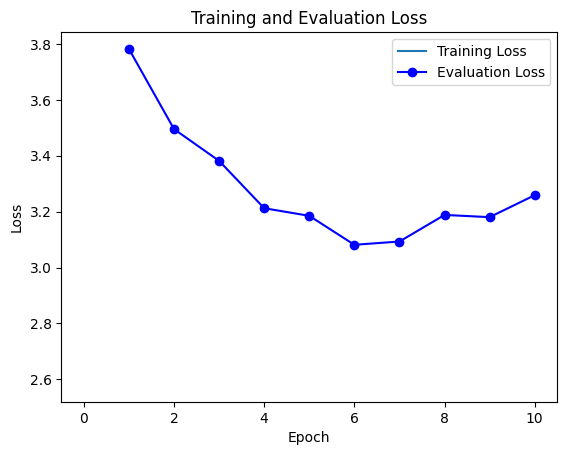

In [33]:
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'eval_loss' not in log]
eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
eval_metrics = [log for log in trainer.state.log_history if 'eval_loss' in log]  # Includes all eval metrics

import matplotlib.pyplot as plt

# Plot training loss
plt.plot(train_losses, label='Training Loss')

# Since evaluation might happen less frequently, you might want to note these points specifically
epochs = range(1, len(eval_losses) + 1)
plt.plot(epochs, eval_losses, 'bo-', label='Evaluation Loss')

plt.title('Training and Evaluation Loss')
plt.xlabel('Step' if len(train_losses) > len(epochs) else 'Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [34]:
question = "What causes the creation of new routes for drug trafficking?"
context = "More than 35 million people worldwide are currently addicted to drugs. COVID-19 has created new routes for drug trafficking that increase the risk of drug addiction, making it vital to address this problem. The aim is to effectively protect the physical health of PWUD and prevent the combination of COVID-19 and the physiological and psychological effects of drugs from affecting relapse behaviour."

In [36]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer)
question_answerer(question=question, context=context)

{'score': 0.024739056825637817,
 'start': 381,
 'end': 398,
 'answer': 'relapse behaviour'}